### Direct Smoothing

In [28]:
# Path
import os, sys
os.chdir('/home/zwang34/IBL/iblfm_exp/IBL_foundation_model')
sys.path.append('./src')
print(sys.path)

import logging
logging.getLogger().setLevel(logging.ERROR)

# Lib
from datasets import load_dataset, concatenate_datasets
import numpy as np
from loader.make_loader import make_loader
from utils.eval_utils import bits_per_spike
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

['/home/zwang34/miniconda3/envs/ibl-fm/lib/python310.zip', '/home/zwang34/miniconda3/envs/ibl-fm/lib/python3.10', '/home/zwang34/miniconda3/envs/ibl-fm/lib/python3.10/lib-dynload', '', '/home/zwang34/miniconda3/envs/ibl-fm/lib/python3.10/site-packages', './src', '/scratch/zwang34/job_33262226/tmp_y2jmoym', './src']


In [37]:
# Fix Args
EID = 'c7bf2d49-4937-4597-b307-9f39cb1c7b16'
kernel_sigma_list = [1, 2, 4, 8, 16, 32]

Generating test split: 100%|██████████| 118/118 [00:00<00:00, 341.09 examples/s]


len(dataset): 118


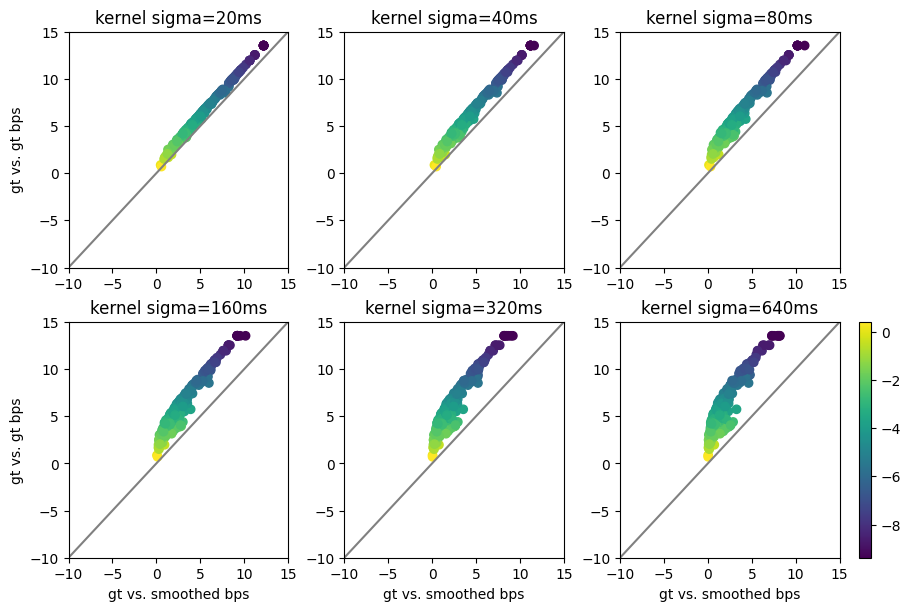

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6), constrained_layout=True)

dataset = load_dataset(f'neurofm123/{EID}_aligned', cache_dir='/expanse/lustre/scratch/zwang34/temp_project/iTransformer/checkpoints/datasets_cache', download_mode='force_redownload')
test_dataset = dataset['test']
n_neurons = len(test_dataset[0]['cluster_uuids'])

test_dataloader = make_loader(
    test_dataset,
    target=None,
    load_meta=True,
    batch_size=8,
    pad_to_right=True,
    pad_value=-1,
    bin_size=0.02,
    max_time_length=100,
    max_space_length=n_neurons,
    dataset_name='ibl',
    shuffle=False,
)

for k, kernel_sigma in enumerate(kernel_sigma_list):       
    gt_list = []
    smoothed_list = []
    for batch in test_dataloader:
        spikes_arr = batch['spikes_data'].detach().cpu().numpy()
        gt_list.append(spikes_arr)
        smoothed_spikes = gaussian_filter1d(spikes_arr, kernel_sigma, axis=1)
        smoothed_list.append(smoothed_spikes)
    
    gt_spikes = np.concatenate(gt_list, axis=0)
    smoothed_spikes = np.concatenate(smoothed_list, axis=0)
    fr_stat = np.log(np.mean(gt_spikes, axis=(0, 1))+1e-9)
    
    bps_smth_list = []
    bps_gt_list = []
    for i in range(n_neurons):
        bps_smth_list.append(bits_per_spike(smoothed_spikes[:, :, [i]], gt_spikes[:, :, [i]]))
        bps_gt_list.append(bits_per_spike(gt_spikes[:, :, [i]], gt_spikes[:, :, [i]]))
    scatter = axes.flat[k].scatter(bps_smth_list, bps_gt_list, c=fr_stat)
    axes.flat[k].set_title(f'kernel sigma={kernel_sigma*20}ms')
    axes.flat[k].set_xlim([-10, 15])
    axes.flat[k].set_ylim([-10, 15])
    axes.flat[k].plot([-10, 15], [-10, 15], c='grey')

axes.flat[0].set_ylabel('gt vs. gt bps')
axes.flat[3].set_ylabel('gt vs. gt bps')
axes.flat[3].set_xlabel('gt vs. smoothed bps')
axes.flat[4].set_xlabel('gt vs. smoothed bps')
axes.flat[5].set_xlabel('gt vs. smoothed bps')
fig.colorbar(scatter)
plt.savefig('smoothing_direct.png')

### Smoothing + Poisson GLM

In [40]:
# Path
import os, sys
os.chdir('/home/zwang34/IBL/iblfm_exp/IBL_foundation_model')
sys.path.append('./src')
print(sys.path)

import logging
logging.getLogger().setLevel(logging.ERROR)

# Lib
from datasets import load_dataset, concatenate_datasets
import numpy as np
from loader.make_loader import make_loader
from utils.eval_utils import bits_per_spike
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

['/home/zwang34/miniconda3/envs/ibl-fm/lib/python310.zip', '/home/zwang34/miniconda3/envs/ibl-fm/lib/python3.10', '/home/zwang34/miniconda3/envs/ibl-fm/lib/python3.10/lib-dynload', '', '/home/zwang34/miniconda3/envs/ibl-fm/lib/python3.10/site-packages', './src', '/scratch/zwang34/job_33262226/tmp_y2jmoym', './src', './src']


In [53]:
## Fix Args
EID = 'c7bf2d49-4937-4597-b307-9f39cb1c7b16'
randomized = True
kernel_sigma = 1  # unit: 20 ms
heldout_ratio = 0.1 
fr_filter = 0.1  # unit: 1 Hz

In [54]:
## Prepare data
if randomized == True:
    dataset = load_dataset(f'neurofm123/{EID}_aligned', cache_dir='/expanse/lustre/scratch/zwang34/temp_project/iTransformer/checkpoints/datasets_cache')
    train_dataset = dataset['train']
    val_dataset = dataset['val']
    test_dataset = dataset['test']
    n_neurons = len(test_dataset[0]['cluster_uuids'])
else:
    raise NotImplementedError("non-randomized split not implemented")

train_dataloader = make_loader(
    train_dataset,
    target=None,
    load_meta=True,
    batch_size=10000,
    pad_to_right=True,
    pad_value=-1,
    bin_size=0.02,
    max_time_length=100,
    max_space_length=n_neurons,
    dataset_name='ibl',
    shuffle=True,
)

val_dataloader = make_loader(
    val_dataset,
    target=None,
    load_meta=True,
    batch_size=10000,
    pad_to_right=True,
    pad_value=-1,
    bin_size=0.02,
    max_time_length=100,
    max_space_length=n_neurons,
    dataset_name='ibl',
    shuffle=False,
)

test_dataloader = make_loader(
    test_dataset,
    target=None,
    load_meta=True,
    batch_size=10000,
    pad_to_right=True,
    pad_value=-1,
    bin_size=0.02,
    max_time_length=100,
    max_space_length=n_neurons,
    dataset_name='ibl',
    shuffle=False,
)

for batch in train_dataloader:
    train_data = batch['spikes_data'].detach().cpu().numpy()
for batch in val_dataloader:
    val_data = batch['spikes_data'].detach().cpu().numpy()
for batch in test_dataloader:
    test_data = batch['spikes_data'].detach().cpu().numpy()

# Use a fr Filter
whole_data = np.concatenate([train_data, val_data, test_data], axis=0)
mean_fr = np.mean(whole_data, axis=(0,1)) * 50   # hz
valid_idx = (mean_fr >= fr_filter)
train_data = train_data[:, :, valid_idx]
val_data = val_data[:, :, valid_idx]
test_data = test_data[:, :, valid_idx]

# Randomly select heldout neurons
n_valid_neurons = train_data.shape[-1]
heldout_idxs = np.random.choice(range(n_valid_neurons), size=int(n_valid_neurons*heldout_ratio), replace=False)
mask = np.ones(n_valid_neurons, dtype=bool)
mask[heldout_idxs] = False

print(f'held-out neurons : held-in neurons = {heldout_idxs.shape[0]} : {n_valid_neurons-heldout_idxs.shape[0]}')

train_spikes_heldin = train_data[:, :, mask]
train_spikes_heldout = train_data[:, :, ~mask]
test_spikes_heldin = test_data[:, :, mask]
test_spikes_heldout = test_data[:, :, ~mask]
val_spikes_heldin = val_data[:, :, mask]
val_spikes_heldout = val_data[:, :, ~mask]

len(dataset): 410
len(dataset): 58
len(dataset): 118
held-out neurons : held-in neurons = 31 : 286


In [55]:
## Adapt. We use Val split as the eval set here.
eval_spikes_heldin = val_spikes_heldin
eval_spikes_heldout = val_spikes_heldout

In [56]:
## Copied from NLB'21 repo
## Define helper function for training Poisson regressor

from sklearn.linear_model import PoissonRegressor

def fit_poisson(train_input, eval_input, train_output, alpha=0.0):
    train_pred = []
    eval_pred = []
    # train Poisson GLM for each output column
    for chan in range(train_output.shape[1]):
        pr = PoissonRegressor(alpha=alpha, max_iter=500)
        pr.fit(train_input, train_output[:, chan])
        train_pred.append(pr.predict(train_input))
        eval_pred.append(pr.predict(eval_input))
    train_pred = np.vstack(train_pred).T
    eval_pred = np.vstack(eval_pred).T
    return train_pred, eval_pred

## Smooth spikes

# Assign useful variables
tlength = train_spikes_heldin.shape[1]
num_train = train_spikes_heldin.shape[0]
num_eval = eval_spikes_heldin.shape[0]
num_heldin = train_spikes_heldin.shape[2]
num_heldout = train_spikes_heldout.shape[2]

'''
# Smooth spikes with 40 ms std gaussian
import scipy.signal as signal
kern_sd_ms = 20
kern_sd = int(round(kern_sd_ms / 20))
window = signal.gaussian(kern_sd * 6, kern_sd, sym=True)
window /= np.sum(window)
filt = lambda x: np.convolve(x, window, 'same')

train_spksmth_heldin = np.apply_along_axis(filt, 1, train_spikes_heldin)
eval_spksmth_heldin = np.apply_along_axis(filt, 1, eval_spikes_heldin)
'''

# use more convenient smoothing function
train_spksmth_heldin = gaussian_filter1d(train_spikes_heldin, kernel_sigma, axis=1)
eval_spksmth_heldin = gaussian_filter1d(eval_spikes_heldin, kernel_sigma, axis=1)

## Generate rate predictions

# Reshape data to 2d for regression
train_spksmth_heldin_s = train_spksmth_heldin.reshape(-1, train_spksmth_heldin.shape[2])
eval_spksmth_heldin_s = eval_spksmth_heldin.reshape(-1, eval_spksmth_heldin.shape[2])
train_spikes_heldout_s = train_spikes_heldout.reshape(-1, train_spikes_heldout.shape[2])

# Train Poisson regressor from log of held-in smoothed spikes to held-out spikes
train_spksmth_heldout_s, eval_spksmth_heldout_s = fit_poisson(
    np.log(train_spksmth_heldin_s + 1e-4), # add constant offset to prevent taking log of 0
    np.log(eval_spksmth_heldin_s + 1e-4),
    train_spikes_heldout_s,
    alpha=0.1,
)

# Reshape data back to the same 3d shape as the input arrays
train_rates_heldin = train_spksmth_heldin_s.reshape((num_train, tlength, num_heldin))
train_rates_heldout = train_spksmth_heldout_s.reshape((num_train, tlength, num_heldout))
eval_rates_heldin = eval_spksmth_heldin_s.reshape((num_eval, tlength, num_heldin))
eval_rates_heldout = eval_spksmth_heldout_s.reshape((num_eval, tlength, num_heldout))

/home/zwang34/miniconda3/envs/ibl-fm/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


#### Note
- held-in neuron rates in both train and eval split are obtained by directly smoothing.
- held-out neuron rates in both train and eval split are obtained by GLM regression.

In [57]:
## Population Bps
train_bps = bits_per_spike(train_rates_heldout, train_spikes_heldout)
eval_bps = bits_per_spike(eval_rates_heldout, eval_spikes_heldout)
print(f"train_heldout_bps: {train_bps}, eval_heldout_bps: {eval_bps}")

train_heldout_bps: 0.30964843074558634, eval_heldout_bps: 0.2510013531031867
